In [899]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [900]:
# Settings
k_folds = 5

In [901]:
xls = pd.ExcelFile('Dataset - LBP RA.xlsx')
dataframe = pd.read_excel(xls, 'Training Dataset')
#dataframe = dataframe[(dataframe["Treatment"] == 1) | (dataframe["Treatment"] == 5)]
dataframe = dataframe[(dataframe["Treatment"] != 5)]
dataframe_original = dataframe.copy(True)
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 0 to 1545
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Treatment                         897 non-null    int64  
 1   Fever                             879 non-null    float64
 2   Duration_of_pain                  877 non-null    float64
 3   Sick_leave                        897 non-null    int64  
 4   Earlier_hospitalization           897 non-null    int64  
 5   Workoverload                      255 non-null    float64
 6   Familiy_history                   897 non-null    int64  
 7   Depression                        897 non-null    int64  
 8   Extremely_nervous                 862 non-null    float64
 9   Stress                            897 non-null    int64  
 10  Relationship_with_colleagues      581 non-null    float64
 11  Irrational_thoughts_risk_lasting  857 non-null    float64
 12  Irrational_t

In [902]:
categorical_columns = ["Treatment", "Weightloss_per_year"]

boolean_columns = [
    "Fever",
    "Sick_leave",
    "Earlier_hospitalization",
    "Workoverload",
    "Familiy_history",
    "Depression",
    "Stress",
    "Uses_analgesics",
    "Uses_corticosteroids",
    "Serious_disease",
    "Neurogenic_signals",
    "Continuous_pain",
    "Nocturnal_pain",
    "Loss_muscle_strength",
    "Trauma",
    "Failure_symptoms",
    "Incoordination",
    "Paidwork",
]

ordinal_columns = [
    "Duration_of_pain",
    "Extremely_nervous",
    "Relationship_with_colleagues",
    "Irrational_thoughts_risk_lasting",
    "Irrational_thoughts_work",
    "Coping_strategy",
    "Kinesiophobia_physical_exercise",
    "Kinesiophobia_pain_stop",
    "Age",
    "neck_pain_intensity",
    "low_back_pain_intensity",
    "arm_left_pain_intensity",
    "arm_right_pain_intensity",
    "leg_left_pain_intensity",
    "leg_right_pain_intensity",
    "working_ability",
]

value_columns = ["Decreased_mobility"]

In [903]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(dataframe)
imputed_data = imputer.transform(dataframe)
dataframe = pd.DataFrame(imputed_data, columns=dataframe.columns)

# Mapping column types
dataframe[value_columns] = dataframe[value_columns].astype("Int64")
dataframe[categorical_columns] = dataframe[categorical_columns].astype("category")
dataframe[boolean_columns] = dataframe[boolean_columns].astype("boolean")

# Mapping 
age_mapping = {
    "0-19": 0,
    "20-29": 1,
    "30-39": 2,
    "40-49": 3,
    "50-59": 4,
    "60-69": 5,
    "70-79": 6,
    ">=80": 7,
}

dataframe["Age"] = dataframe["Age"].replace(age_mapping)

for column in ordinal_columns:
    dataframe[[column]] = dataframe[[column]].astype("Int64")
    dataframe[column] = pd.Categorical(dataframe[column], categories=sorted(dataframe[column].unique()), ordered=True)

In [904]:
# Filter columns
missing_percentages = dataframe_original.isnull().mean()
columns_to_remove = missing_percentages[missing_percentages > 0.7].index.tolist()
dataframe = dataframe.drop(columns=columns_to_remove)

categorical_columns = [
    col for col in categorical_columns if col not in columns_to_remove
]
ordinal_columns = [col for col in ordinal_columns if col not in columns_to_remove]
boolean_columns = [col for col in boolean_columns if col not in columns_to_remove]
value_columns = [col for col in value_columns if col not in columns_to_remove]

In [905]:
# Duplicate data (duplication is only used for training and overrepresenting minority data)
X = dataframe.drop(columns=["Treatment"])
y = dataframe["Treatment"]

minority_data = dataframe[(dataframe["Treatment"] != 1) & (dataframe["Treatment"] != 5)]
minority_data = pd.concat([minority_data] * 2)
minority_X = minority_data.drop(columns=["Treatment"])
minority_y = minority_data["Treatment"]
train_X = pd.concat([minority_X, X], axis=0)
train_y = pd.concat([minority_y, y], axis=0)

In [906]:
print("Number of rows for each unique value of the Treatment column:")
print(dataframe["Treatment"].value_counts())

combined_train = pd.concat([train_X, train_y], axis=1)
print("Number of rows for each unique value of the Treatment column in the combined dataset:")
print(combined_train["Treatment"].value_counts())

Number of rows for each unique value of the Treatment column:
Treatment
1    659
2    160
3     65
4     13
Name: count, dtype: int64
Number of rows for each unique value of the Treatment column in the combined dataset:
Treatment
1    659
2    480
3    195
4     39
Name: count, dtype: int64


In [907]:
feature_selector = SelectKBest(score_func=f_classif)
selected_features = feature_selector.fit_transform(train_X, train_y)
selected_feature_indices = feature_selector.get_support(indices=True)
remaining_features = train_X.columns[~selected_feature_indices]

boolean_columns = [col for col in boolean_columns if col in remaining_features]
categorical_columns = [col for col in categorical_columns if col in remaining_features]
ordinal_columns = [col for col in ordinal_columns if col in remaining_features]
value_columns = [col for col in value_columns if col in remaining_features]

train_X = train_X[remaining_features]

print("Remaining Features:")
print(remaining_features)

Remaining Features:
Index(['Paidwork', 'Incoordination', 'Nocturnal_pain', 'Decreased_mobility',
       'Neurogenic_signals', 'Serious_disease', 'Uses_corticosteroids',
       'Kinesiophobia_pain_stop', 'Earlier_hospitalization', 'Fever'],
      dtype='object')


In [908]:
preprocessor = ColumnTransformer(
    transformers=[
        ('bool', 'passthrough', boolean_columns),       # No transformation for boolean columns
        ('cat', OneHotEncoder(), categorical_columns),  # One-hot encoding for categorical columns
        # ('ord', LabelEncoder(), ordinal_columns),       # Label encoding for ordinal columns
        ('num', StandardScaler(), value_columns)        # Standard scaling for numeric columns
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('svm', SVC())])

# SVM
param_grid_svm = {"svm__kernel": ["linear", "rbf", "poly"],}
grid_search_svm = GridSearchCV(pipeline, param_grid_svm, cv=k_folds, scoring="f1")
grid_search_svm.fit(train_X, train_y)

c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\sklearn\utils\_param_validation.py", lin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('bool',
                                                                         'passthrough',
                                                                         ['Fever',
                                                                          'Earlier_hospitalization',
                                                                          'Uses_corticosteroids',
                                                                          'Serious_disease',
                                                                          'Neurogenic_signals',
                                                                          'Nocturnal_pain',
                                                                          'Incoordination',
                                                                          'Paidwork']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         []),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['Decreased_mobility'])])),
                                       ('svm', SVC())]),
             param_grid={'svm__kernel': ['linear', 'rbf', 'poly']},
             scoring='f1')

In [909]:


# Define Grid search params
param_grid_tree = {
    "max_depth": [2, 3, 4, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

param_grid_random_forest = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [None, 10, 20],
}

param_grid_gradient_boosting = {
    "estimator__learning_rate": [0.01, 0.1, 0.5],
}

param_grid_knn = {"n_neighbors": [3, 5, 10]}

param_grid_logistic_regression = {"C": [0.1, 1.0, 10.0], "penalty": ["l1", "l2"]}

param_grid_neural_network = {
    "hidden_layer_sizes": [(100,), (50, 50), (50, 100, 50)],
    "alpha": [0.0001, 0.001, 0.01],
}

# Perform grid searchfor each model
# grid_search_tree = GridSearchCV(
#     DecisionTreeClassifier(), param_grid_tree, cv=k_folds, scoring="accuracy"
# )
# grid_search_tree.fit(train_X, train_y)

# grid_search_random_forest = GridSearchCV(
#     OneVsRestClassifier(RandomForestClassifier()),
#     param_grid_random_forest,
#     cv=k_folds,
#     scoring="accuracy",
# )
# grid_search_random_forest.fit(train_X, train_y)

# grid_search_gradient_boosting = GridSearchCV(
#     OneVsRestClassifier(HistGradientBoostingClassifier()),
#     param_grid_gradient_boosting,
#     cv=k_folds,
#     scoring="accuracy",
# )
# grid_search_gradient_boosting.fit(train_X, train_y)

# grid_search_knn = GridSearchCV(
#     KNeighborsClassifier(), param_grid_knn, cv=k_folds, scoring="accuracy"
# )
# grid_search_knn.fit(train_X, train_y)

# grid_search_logistic_regression = GridSearchCV(
#     LogisticRegression(max_iter=4000, solver="saga"),
#     param_grid_logistic_regression,
#     cv=k_folds,
#     scoring="accuracy",
# )
# grid_search_logistic_regression.fit(train_X, train_y)

# grid_search_neural_network = GridSearchCV(
#     MLPClassifier(max_iter=4000),
#     param_grid_neural_network,
#     cv=k_folds,
#     scoring="accuracy",
# )
# grid_search_neural_network.fit(train_X, train_y)



In [910]:
models = [
    # ("Decision Tree", grid_search_tree.best_estimator_),
    # ("Random Forest", grid_search_random_forest.best_estimator_),
    # ("Gradient Boosting", grid_search_gradient_boosting.best_estimator_),
    # ("KNN", grid_search_knn.best_estimator_),
    # ("Logistic Regression", grid_search_logistic_regression.best_estimator_),
    # ("Neural Network", grid_search_neural_network.best_estimator_),
    ("SVM", grid_search_svm.best_estimator_),
]

model_scores = {}
confusion_matrices = {}

for name, model in models:
    scores = cross_val_score(model, X, y, cv=k_folds, scoring="accuracy")
    model_scores[name] = scores
    y_pred = cross_val_predict(model, X, y, cv=k_folds)
    cm = confusion_matrix(y, y_pred)
    cmn = cm.astype("int") / cm.sum(axis=1)[:, np.newaxis]

    confusion_matrices[name] = cmn

    print(f"{name}: Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")


average_accuracy = np.mean([scores.mean() for scores in model_scores.values()])
print(f"Average Accuracy Across All Models: {average_accuracy:.4f}")

ensemble_model = VotingClassifier(estimators=models, voting="hard")
scores = cross_val_score(ensemble_model, X, y, scoring="accuracy")

print(
    f"Ensemble Model (Voting): Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})"
)

SVM: Accuracy: 0.6269 (+/- 0.4325)
Average Accuracy Across All Models: 0.6269
Ensemble Model (Voting): Accuracy: 0.6269 (+/- 0.4325)


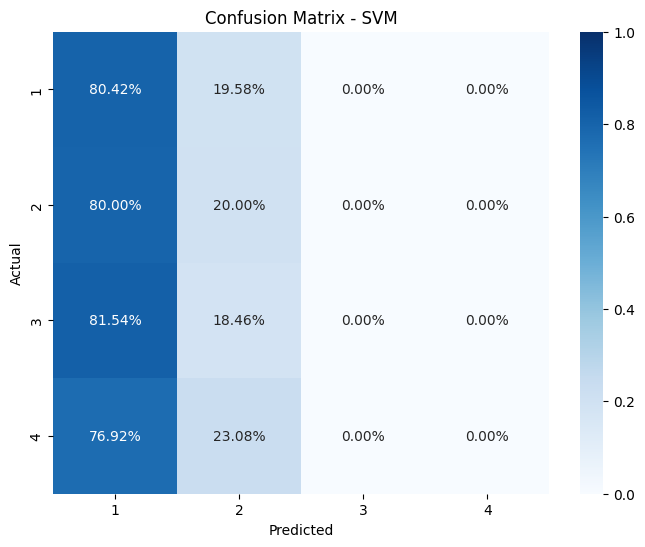

In [911]:
labels = np.unique(y)
for name, cmn in confusion_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(cmn, annot=True, cmap='Blues', fmt='.2%', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1.0)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()